# Loan Status Prediction Model - RandomForestClassifier

In [304]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, PrecisionRecallDisplay

In [305]:
app_data = pd.read_csv('/kaggle/input/credit-card-approval-prediction/application_record.csv')
app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [306]:
app_data.shape

(438557, 18)

In [307]:
credit_data = pd.read_csv('/kaggle/input/credit-card-approval-prediction/credit_record.csv')
credit_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [308]:
credit_data.shape

(1048575, 3)

In [309]:
df = pd.merge(app_data, credit_data, on='ID' , how='inner')
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [310]:
df.shape

(777715, 20)

In [311]:
df.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
MONTHS_BALANCE           int64
STATUS                  object
dtype: object

In [312]:
df.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        240048
CNT_FAM_MEMBERS             0
MONTHS_BALANCE              0
STATUS                      0
dtype: int64

Looks like all null values are in the occupation_type column. Look like a big number, what percent of the total is that?

In [313]:
print("Percent null of occupation_type values is:")
df['OCCUPATION_TYPE'].isna().sum() / df.shape[0] * 100

Percent null of occupation_type values is:


30.86580559716606

In [314]:
df.drop('OCCUPATION_TYPE', axis=1, inplace=True)
df.shape

(777715, 19)

Now we want to consider any duplicates. Additionally, we want to convert any outstanding status to 0, and complete or no loan status to 1. This simplifies our final findings of whether or not an individual will be credit risky or not.

In [315]:
df.nunique()

ID                     36457
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
FLAG_MOBIL                 1
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
CNT_FAM_MEMBERS           10
MONTHS_BALANCE            61
STATUS                     8
dtype: int64

In [316]:
df.duplicated().sum()

0

This means that there are 36457 unique IDs, but with no duplicate rows considering the months_balances are different, as we can see below for the same ID rows

In [317]:
df[df['ID'].duplicated()].head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-4,C
5,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-5,C
6,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-6,C
7,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-7,C
8,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-8,C
9,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-9,C
10,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-10,C


### Encoding loan status
Next, I will replace every number >= 0 in the status column by 0, representing outstanding loan, 1 representing complete, and -1 representing no loan. This will simplify the model's options for predictions.

I will also make a new column that shows these values in terms of strings

In [318]:
df['STATUS'] = df['STATUS'].astype(str)

In [319]:
def status_convert(x):
    if x == "C":
        return "good"
    elif x == "X":
        return "none"
    else:
        num = float(x)
        if num >= 0:
            return "bad"
        else:
            return -100

In [320]:
def status_convert_num(x):
    if x == "C":
        return 1
    elif x == "X":
        return -1
    else:
        num = float(x)
        if num >= 0:
            return 0
        else:
            return -100

In [321]:
df['loan_status'] = df['STATUS'].apply(status_convert_num)
df['STATUS'] = df['STATUS'].apply(status_convert)

Now the status has been successfully converted to -1, 0, or 1s, as shown below.

In [322]:
df['STATUS'].head(20).values

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'none',
       'good', 'good', 'good', 'good'], dtype=object)

In [323]:
df['loan_status'].head(20).values

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0, -1,  1,
        1,  1,  1])

### Converting "days_birth" to useful ages, as they are currently in negative days since birth.

In [324]:
df['DAYS_BIRTH'] = round(df['DAYS_BIRTH']*(-1)/365, 0)

### Renaming columns for convenience

In [325]:
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS',
       'loan_status'],
      dtype='object')

In [326]:
df.rename(columns={
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'own_car',
    'FLAG_OWN_REALTY': 'own_property',
    'CNT_CHILDREN': 'children',
    'AMT_INCOME_TOTAL': 'income',
    'NAME_INCOME_TYPE': 'income_type',
    'NAME_EDUCATION_TYPE': 'education',
    'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type',
    'FLAG_MOBIL': 'mobile',
    'FLAG_WORK_PHONE': 'work_phone',
    'FLAG_PHONE': 'phone',
    'FLAG_EMAIL': 'email',
    'CNT_FAM_MEMBERS': 'family_members',
    'MONTHS_BALANCE': 'months_balance',
    'STATUS' : 'status',
    'DAYS_BIRTH' : 'age',
    'DAYS_EMPLOYED' : 'employment_in_days'

} , inplace=True)

df.columns

Index(['ID', 'gender', 'own_car', 'own_property', 'children', 'income',
       'income_type', 'education', 'family_status', 'housing_type', 'age',
       'employment_in_days', 'mobile', 'work_phone', 'phone', 'email',
       'family_members', 'months_balance', 'status', 'loan_status'],
      dtype='object')

# Finding Insights in the Data
Our target variable is loan_status. We will find insights on possible features and analyze their relationship with the target variable.

- attribute distribution
- relationship between different attributes
- relationship between attributes and target 

In [327]:
df['status'].value_counts()

status
good    329536
bad     302229
none    145950
Name: count, dtype: int64

Column graphs, correlation matrices, Pi charts, box and whisker plots

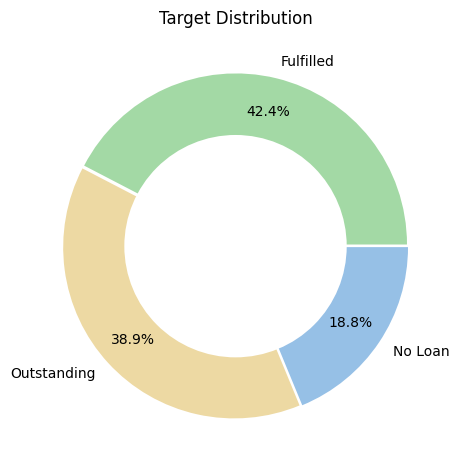

In [328]:
sizes = df['status'].value_counts()
labels = ['Fulfilled', 'Outstanding', 'No Loan']
colors = ['#a3d9a5', '#edd9a3', '#96c0e6']
explode = [0.01, 0.01, 0.01]


plt.pie(sizes, colors=colors, labels=labels,
        autopct='%1.1f%%', pctdistance=0.80, explode=explode)
 
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig = plt.gcf()
 
fig.gca().add_artist(centre_circle)
 
plt.title('Target Distribution')
plt.tight_layout()
 
plt.show()

## Examining other distributions:
'gender', 'own_car', 'own_property', 'children', 'income',
       'income_type', 'education', 'family_status', 'housing_type',
       'age_in_days', 'employment_in_days'

### Starting with **gender**, **own_car**, and **own_property** since they are simple categorical-type variables

In [329]:
# gender, own_car, own_property (since they are one or the other)

print(df['gender'].value_counts(), "\n")
print(df['own_car'].value_counts(), "\n")
print(df['own_property'].value_counts())

gender
F    518851
M    258864
Name: count, dtype: int64 

own_car
N    473355
Y    304360
Name: count, dtype: int64 

own_property
Y    512948
N    264767
Name: count, dtype: int64


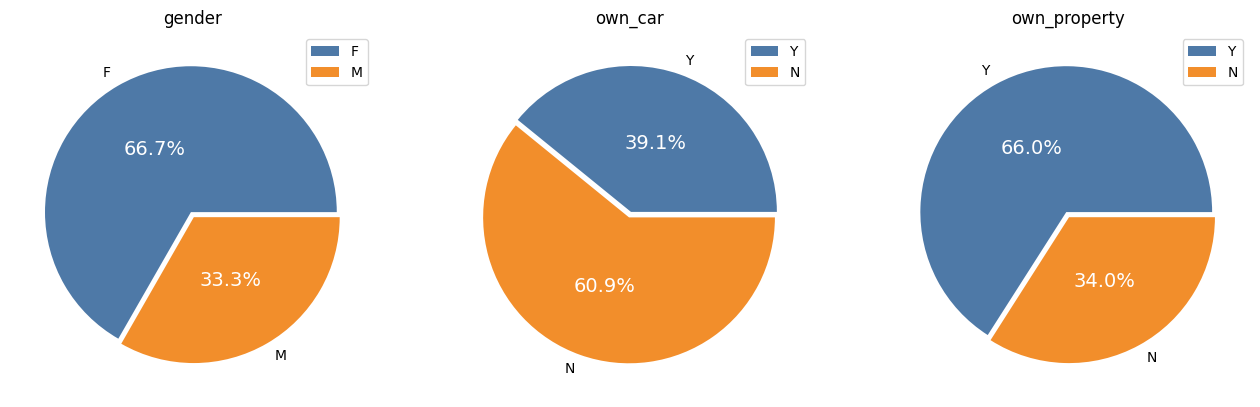

In [330]:
# Define the list of column names
columns = ['gender', 'own_car', 'own_property']
explode = [0.02, 0.02]

colors = ['#4e79a7', '#f28e2b']  # Colors for the 'gender' pie chart

# Create subplots for each column
plt.figure(figsize=(16, 9))  # Adjust the figure size as needed

for i in range(len(columns)):
    plt.subplot(1, 3, i+1)
    plt.title(columns[i])  # Use the column name as the title
    
    # Create pie chart
    counts = df[columns[i]].value_counts()
    if columns[i] == 'own_car':
        counts = counts.reindex(['Y', 'N'])
        
    wedges, texts, autotexts = plt.pie(counts, labels=counts.index, autopct='%1.1f%%', pctdistance=0.50, 
                                       explode=explode, colors=colors)
    
    # Customize autotexts
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_size(14)
    
    # Add legend with unique values
    plt.legend(counts.index, loc='upper right')

plt.show()

**Observations:**
- aofun
whjef
wekjf

### Relationship with loan status:

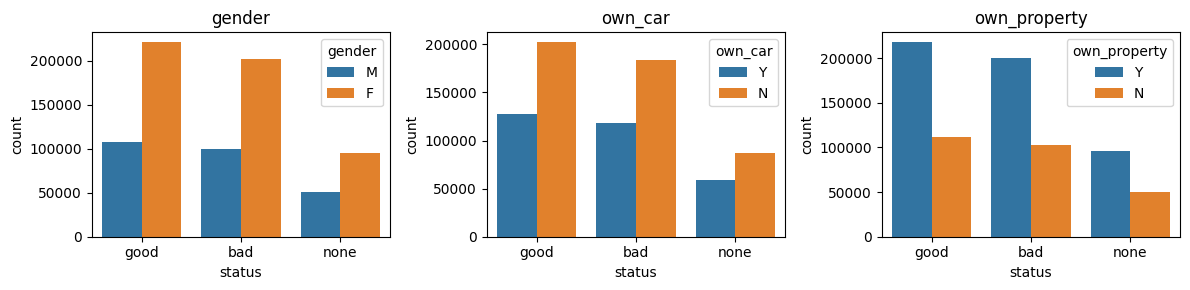

In [331]:
# Define the list of column names
class_vars = ['gender', 'own_car', 'own_property']

colors = ['#4e79a7', '#f28e2b']  

plt.figure(figsize=(12, 3))

for i in range(len(class_vars)):
    plt.subplot(1, 3, i+1)
    plt.title(class_vars[i])  
    sns.countplot(data=df, x=df['status'], hue=df[class_vars[i]])

plt.tight_layout()
plt.show()

then, age graph with good loans, bad loans, no loans, total loans

### Next Considering family_members/children and loan_status

In [332]:
df.family_members.value_counts()

family_members
2.0     423723
1.0     141477
3.0     134894
4.0      66990
5.0       8999
6.0       1196
7.0        273
15.0       111
9.0         46
20.0         6
Name: count, dtype: int64

In [333]:
df.children.value_counts()

children
0     540639
1     155638
2      70399
3       9328
4       1224
5        324
14       111
7         46
19         6
Name: count, dtype: int64

In [334]:
age = df.groupby('family_members')[['children', 'income_type', 'status']].value_counts()
age.unstack()

status                                            bad     good     none
family_members children income_type                                    
1.0            0        Commercial associate  12069.0  14014.0   5765.0
                        Pensioner             14484.0  16350.0   7493.0
                        State servant          3960.0   4377.0   1689.0
                        Student                  11.0      4.0      NaN
                        Working               24970.0  25042.0  10993.0
               1        Commercial associate     25.0     32.0      NaN
                        Working                  55.0     37.0     40.0
               2        Commercial associate     11.0     25.0      NaN
                        Working                  18.0     13.0      NaN
2.0            0        Commercial associate  35180.0  37472.0  17446.0
                        Pensioner             33149.0  37431.0  15282.0
                        State servant         11709.0  13042.0   5450.0
                        Student                  41.0    196.0     57.0
                        Working               74041.0  82340.0  36582.0
               1        Commercial associate   2888.0   2552.0   1390.0
                        Pensioner                10.0      NaN      4.0
                        State servant           862.0    978.0    540.0
                        Working                5574.0   7120.0   2387.0
3.0            1        Commercial associate  14606.0  14109.0   6605.0
                        Pensioner              1441.0   1111.0    559.0
                        State servant          5295.0   5412.0   2875.0
                        Student                  16.0      NaN     12.0
                        Working               30266.0  32769.0  16068.0
               2        Commercial associate    228.0    287.0    359.0
                        Pensioner                21.0     52.0      7.0
                        State servant            68.0     26.0     43.0
                        Working                1053.0   1123.0    483.0
4.0            2        Commercial associate   6667.0   6733.0   2713.0
                        Pensioner               324.0    371.0     74.0
                        State servant          3105.0   3427.0   1623.0
                        Working               15757.0  18428.0   7360.0
               3        Commercial associate     85.0      NaN      5.0
                        Pensioner                28.0     22.0     27.0
                        Working                 181.0     56.0      4.0
5.0            3        Commercial associate    652.0    841.0    214.0
                        Pensioner                41.0     18.0     93.0
                        State servant           362.0    216.0    132.0
                        Working                2269.0   2990.0   1092.0
               4        State servant            49.0      3.0     27.0
6.0            4        Commercial associate    156.0    230.0     26.0
                        State servant           121.0      3.0     43.0
                        Working                 185.0    180.0    201.0
               5        Working                  22.0     29.0      NaN
7.0            5        Working                  57.0     53.0    163.0
9.0            7        Working                  24.0     22.0      NaN
15.0           14       Working                  87.0      NaN     24.0
20.0           19       Working                   6.0      NaN      NaN

**Observations:**
- 1 family member with 2 kids? interesting ...
- otherwise, *put analysis*

## Age and Loan Status 

## Remaining observations:
## - education, housing, income_type, income_amount, employment

# Preprocessing
- Getting rid of outliers in numerical fields
- Explaining why random forest works
- correlation matrix to check which fields are independent
- check multicollinearlity through variance
- label encoding for categorical features
- standardization

In [336]:
df.columns

Index(['ID', 'gender', 'own_car', 'own_property', 'children', 'income',
       'income_type', 'education', 'family_status', 'housing_type', 'age',
       'employment_in_days', 'mobile', 'work_phone', 'phone', 'email',
       'family_members', 'months_balance', 'status', 'loan_status'],
      dtype='object')

Let's look at the box and whisker plots for our numerical fields

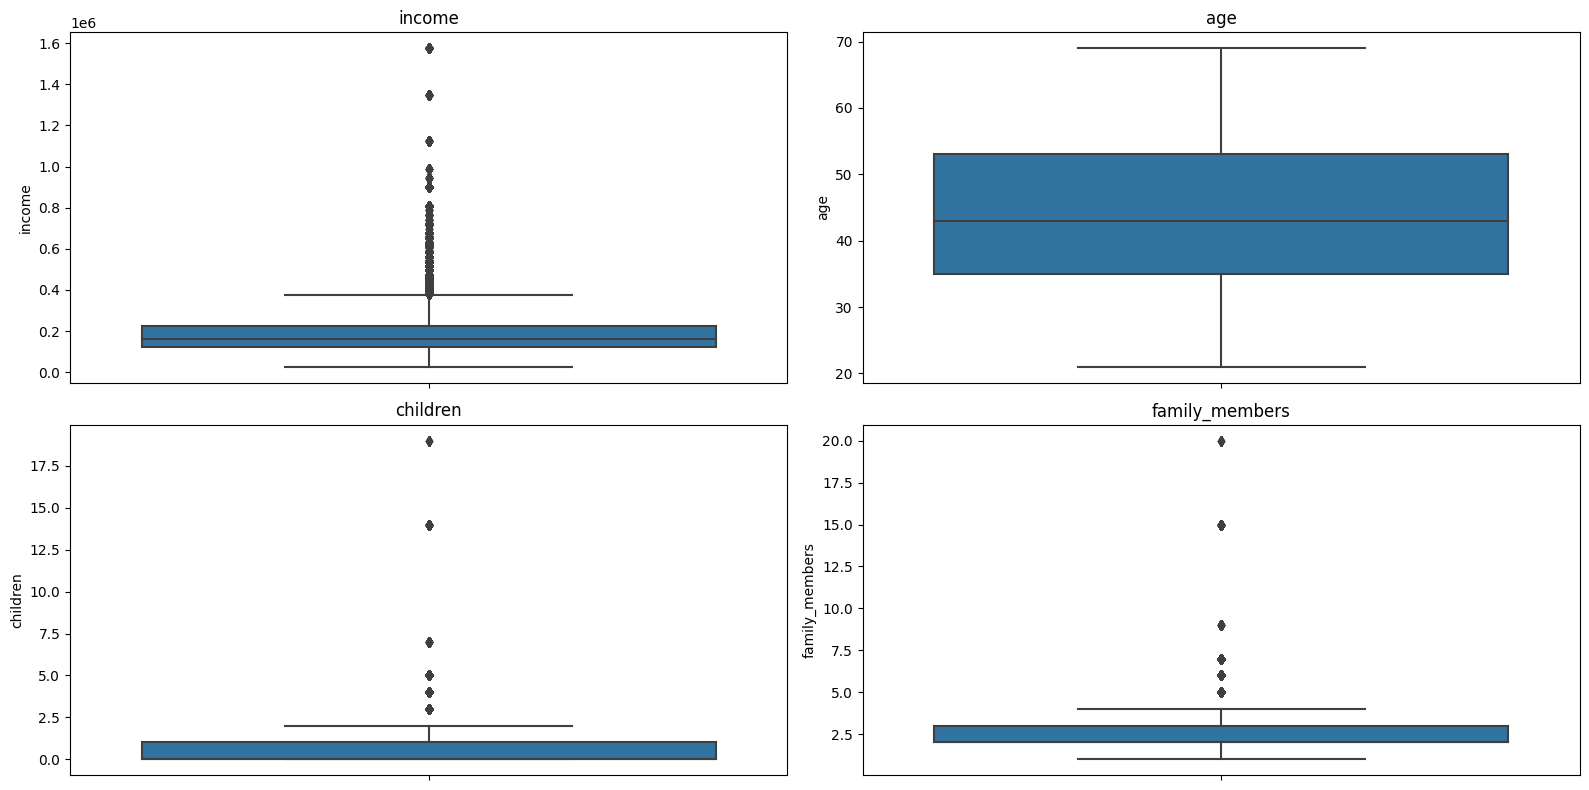

In [337]:
col = ['income', 'age', 'children', 'family_members' ]

plt.figure(figsize=(16, 8))

for i in range(len(col)):
    plt.subplot(2, 2, i+1)
    plt.title(col[i]) 
    sns.boxplot(data=df, y=col[i])

plt.tight_layout()  
plt.show()

We can see outliers in the columns chilren, family members, and income. Let's get rid of those to better generalize the model and **prevent overfitting**

## We will use some statistical tools and consider quartile ranges to deal with these outliers.

In [338]:
col = ['children', 'income' , 'family_members']

for i in range(len(col)):

    ## find quartile ranges
    q1 = df[col[i]].quantile(0.25)
    q3 = df[col[i]].quantile(0.75)
    iqr = q3 - q1

    ## get upper and lower ranges
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    ## filter out range outside upper and lower 
    df[col[i]] = np.where((df[col[i]] >= upper) | (df[col[i]] <= lower), df[col[i]].median() , df[col[i]])

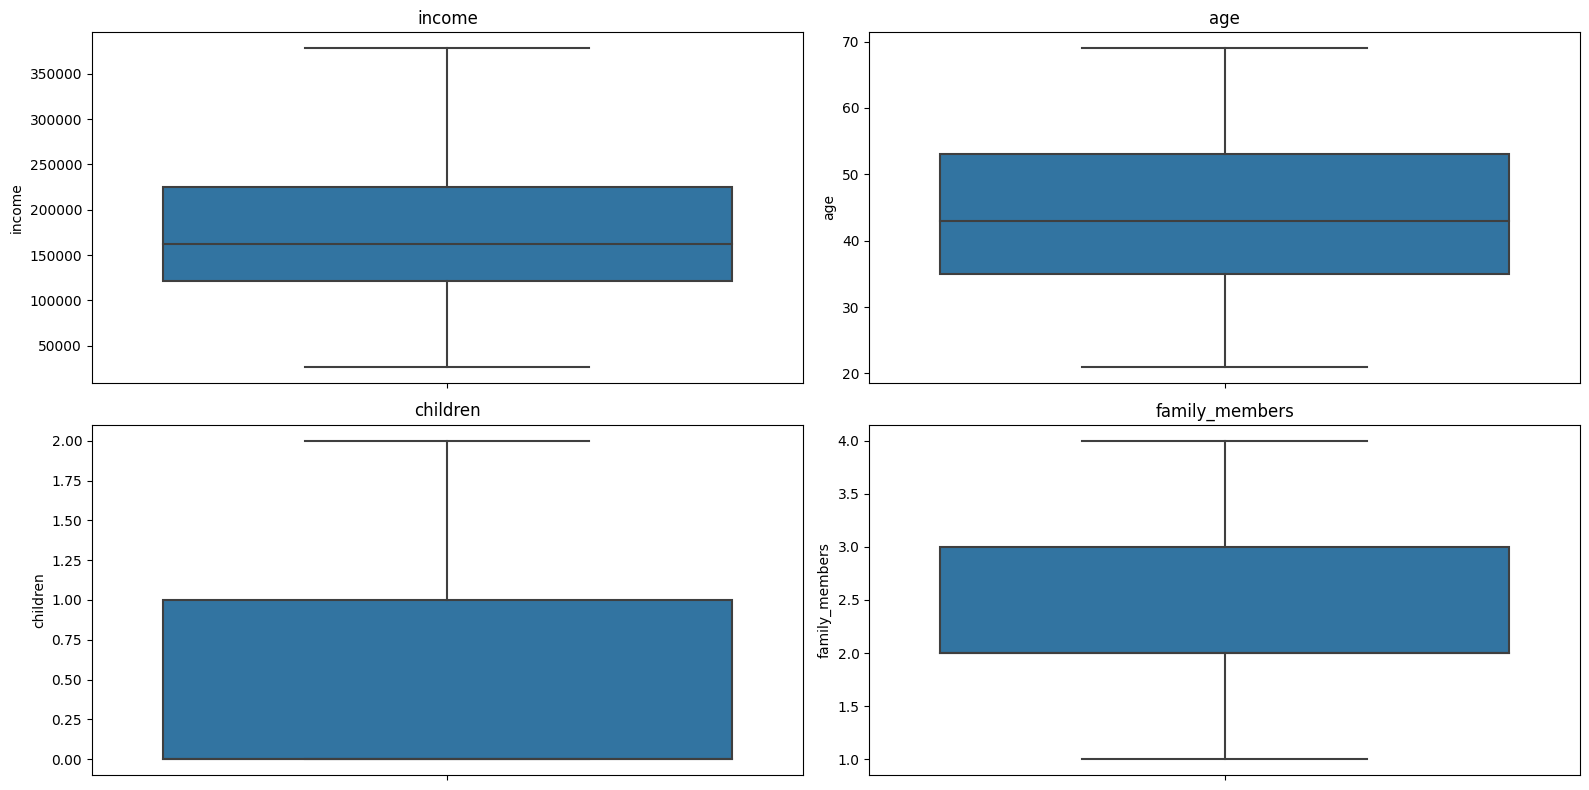

In [339]:
col = ['income', 'age', 'children', 'family_members' ]

plt.figure(figsize=(16, 8))

for i in range(len(col)):
    plt.subplot(2, 2, i+1)
    plt.title(col[i]) 
    sns.boxplot(data=df, y=col[i])

plt.tight_layout()  
plt.show()

Outliers have now been removed.
Now we can **standardize** the numeric columns to fascilitate the model's interpretation.

### Standardization

In [340]:
col = ['income', 'age', 'children', 'family_members']

scale = StandardScaler()
for i in col:
    df[i] = scale.fit_transform(df[[i]])

In [341]:
df.filter(['income', 'age', 'children', 'family_members']).head()

,income,age,children,family_members
0,-0.168401,-0.994109,-0.590317,-0.199667
1,-0.168401,-0.994109,-0.590317,-0.199667
2,-0.168401,-0.994109,-0.590317,-0.199667
3,-0.168401,-0.994109,-0.590317,-0.199667
4,-0.168401,-0.994109,-0.590317,-0.199667


### Label Encoding 
Changing all categorical features into numbers for the model to deal with

In [342]:
col = ['gender', 'own_car', 'own_property', 'income_type','education', 'family_status', 'housing_type']

le = LabelEncoder()

for i in col:
    df[i] =le.fit_transform(df[i] )

## Feature Selection

We will look at a correlation matrix to find any highly correlated elements. It would be efficient to remove these elements, as they would only slow down computation time and not provide much extra insight to the model.

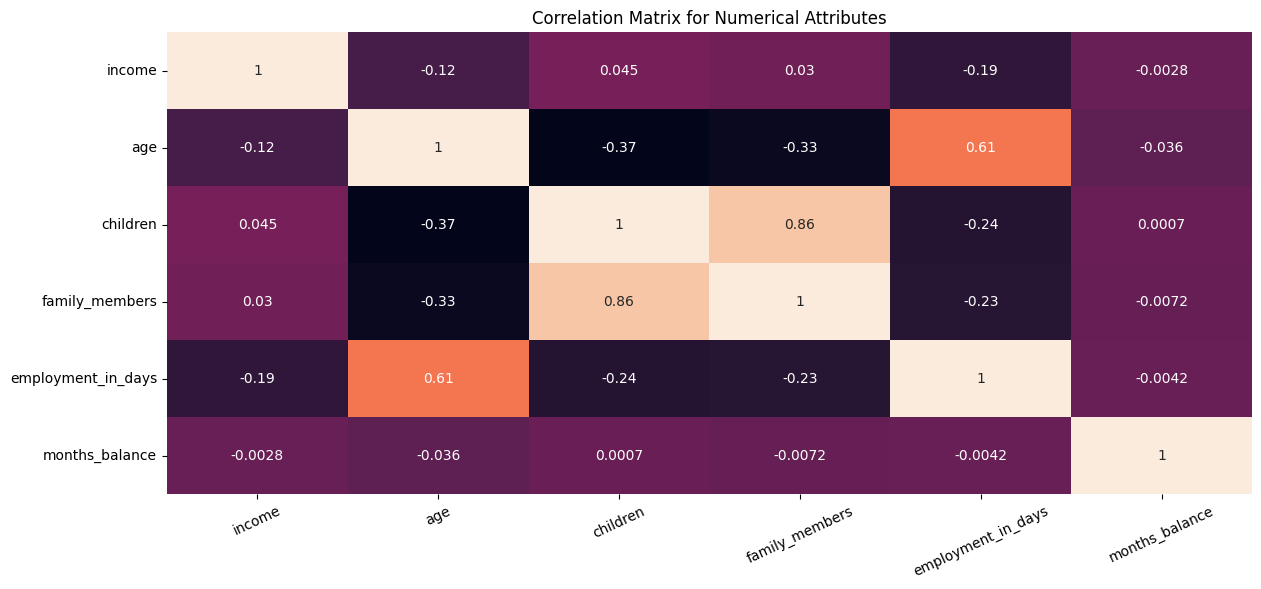

In [343]:
plt.figure(figsize=(14, 6))

sns.heatmap(df[['income', 'age', 'children', 'family_members', 'employment_in_days', 'months_balance']].corr(), annot=True , cbar=False) 

plt.xticks(rotation=25)
plt.title('Correlation Matrix for Numerical Attributes')
plt.show()

### **Analysis**

As we can see from the heatmap, children and family_members are highly correlated. Additionally, age and employment_in_days are relatively correlated as well. Both of these make sense logically. As such, it would be efficient to remove children from the list of features, but there are more intricacies involved in age and employment_in_days so we will keep them.

Moreover, all contact information and ID related attributes are not relevant to the model, so those can be dropped as well.

# Model Development

In [344]:
X = df.drop(['loan_status', 'status', 'mobile', 'children', 'family_members'], axis = 1)

y = df['loan_status']

In [345]:
X.columns

Index(['ID', 'gender', 'own_car', 'own_property', 'income', 'income_type',
       'education', 'family_status', 'housing_type', 'age',
       'employment_in_days', 'work_phone', 'phone', 'email', 'months_balance'],
      dtype='object')

### **Train Test Split**

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [347]:
forest = RandomForestClassifier()

In [348]:
X.head()

,ID,gender,own_car,own_property,income,income_type,education,family_status,housing_type,age,employment_in_days,work_phone,phone,email,months_balance
0,5008804,1,1,1,-0.168401,4,1,0,4,-0.994109,-4542,1,0,0,0
1,5008804,1,1,1,-0.168401,4,1,0,4,-0.994109,-4542,1,0,0,-1
2,5008804,1,1,1,-0.168401,4,1,0,4,-0.994109,-4542,1,0,0,-2
3,5008804,1,1,1,-0.168401,4,1,0,4,-0.994109,-4542,1,0,0,-3
4,5008804,1,1,1,-0.168401,4,1,0,4,-0.994109,-4542,1,0,0,-4


### Fitting the model

In [349]:
forest.fit(X_train, y_train)

RandomForestClassifier()

### Testing the model

In [350]:
y_pred = forest.predict(X_test)

In [351]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(10)

,Actual,Predicted
489996,0,0
293437,0,0
544675,0,0
688170,1,1
582519,-1,0
248623,1,1
476807,0,0
693691,1,1
89611,1,1
756662,1,1


## Model Results

Classification Report:
              precision    recall  f1-score   support

          -1       0.83      0.78      0.81     29029
           0       0.86      0.89      0.88     60288
           1       0.95      0.95      0.95     66226

    accuracy                           0.90    155543
   macro avg       0.88      0.87      0.88    155543
weighted avg       0.89      0.90      0.89    155543

--------------------------------------------------
Accuracy Score : 90%
Precision Score : 90%
F1-Score : 90%
--------------------------------------------------


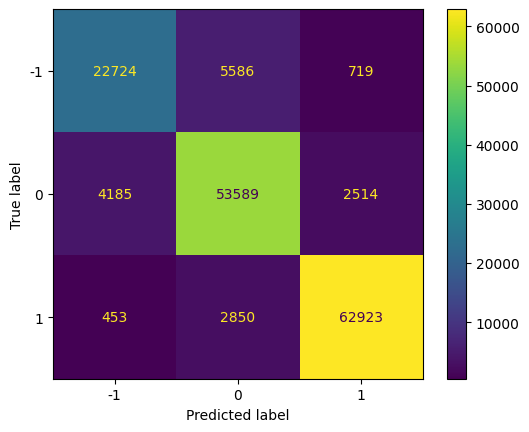

In [360]:
print("Classification Report:")
print(classification_report(y_test,y_pred))

print('-'*50)

print(f"Accuracy Score : {accuracy_score(y_test, y_pred)*100:.0f}%")
print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro')*100:.0f}%")
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')*100:.0f}%")

print('-'*50)

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

* ## Roughly 90% Accuracy with 90% F1 (harmonic mean of precision and recall). Good results!

In [353]:
## Was going to make a function to be able to test multiple models but got tired of waiting.

# def model_doing(model):
    
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     print("Classification Report:")
#     print(classification_report(y_test,y_pred))
#     print('-'*50)
    
#     ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
#     PrecisionRecallDisplay.from_predictions(y_test,y_pred)

#     acc = accuracy_score(y_test,y_pred)
#     precision = precision_score(y_test,y_pred,average='macro')
#     recall = recall_score(y_test,y_pred,average='macro')
#     f1 = f1_score(y_test,y_pred,average='macro')

# Hyperparameter Tuning 
### (Decided not to, since original results were good enough and takes too much time)

Using RandomSearchCV to find the ideal combination of n_estimators and max_depth for the model. n_estimators is the amount of decision trees and max_depth is the maximum height of each tree.

The combination of these two factors is very delicate, and can drastically change both the computational burden and overfitting/underfitting of the model. As such, hyperparameter tuning can improve model results. 

In [361]:
# param_dist = {'n_estimators': stats.randint(50,300),
#               'max_depth': stats.randint(1,15)}

# rf = RandomForestClassifier()

# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(rf, 
#                                  param_distributions = param_dist, 
#                                  n_iter=4, 
#                                  cv=4)

# # Fit the random search object to the data
# rand_search.fit(X_train, y_train)

**Note: RandomizedSearchCV increases computation time by several minutes**

### Best parameters

In [ ]:
# best_rf = rand_search.best_estimator_

# print('Best hyperparameters:',  rand_search.best_params_)

In [ ]:
# y_pred = best_rf.predict(X_test)

## New Results

In [ ]:
# y_pred = knn.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

# print(classification_report(y_test,y_pred))

# print("-"*50)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)

# print("-"*50)

# ConfusionMatrixDisplay.from_predictions(y_test,y_pred)